# <B> CS517 Project </B>
## GVF Snakes (Active contours)

### 1. Package Imports

In [33]:
import sys
import skimage.color
import skimage.data
import skimage.transform
import skimage.io
import skimage.filters as skimage_filter
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

### 2. File input


Enter image path: 

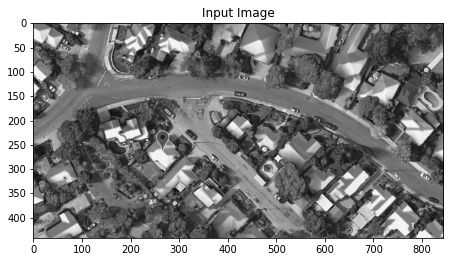

In [34]:
print("Enter image path: ", end = "")
imgPath = "a.png"
try:
    # taking image as input
    # converting into grayscale
    img = cv2.imread(imgPath, 0)
    # img = skimage.color.rgb2gray(skimage.io.imread(imgPath))
except:
    # in case file is not found
    print("Image path incorrect.")
    exit(0)

img2 = img.copy()
img2 = img2.astype(np.float32) 
img2 = img / 255 # rescaling the pixel values

plt.figure(figsize=(25,25))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(img, cmap="gray")

### 3. Edge Map

To get the GVF field, the first step is to extract 
the edge map function $E$(x, y) from the image $I$(x, y). 
A suitable edge map function can be given as follows:

$f_{1}$(x, y) = −$I$(x, y)

$f_{2}$(x, y) = −$G_{σ}$(x , y)∗$I$(x , y)

where $G_{σ}$(x , y) is a two dimension gaussian function with standard deviation $σ$. 


In [35]:
blurImg = skimage_filter.gaussian(img, 2) 
edgeMap = skimage_filter.sobel(blurImg)

### 4. Gradient field

In [ ]:
tempIm = edgeMap.copy()
tempIm = skimage_filter.gaussian(tempIm, 1)

"""
numpy.hstack() function is used to stack the sequence of input arrays horizontally 
(i.e. column wise) to make a single array.

numpy.vstack() function is used to stack the sequence of input arrays vertically 
(i.e. row wise) to make a single array.

"""

gradientX = np.hstack([tempIm[:, 1:], tempIm[:, -2:-1]]) - np.hstack([tempIm[:, 0:1], tempIm[:, :-1]]) 
gradientY = np.vstack([tempIm[1:, :], tempIm[-2:-1, :]]) - np.vstack([tempIm[0:1, :], tempIm[:-1, :]]) 

### 5. Gradient Vector field

In [ ]:
# calc some coefficients.
mu = 1.0
dx = 1.0
dy = 1.0
b = gradientX**2.0 + gradientY**2.0
c1, c2 = b*gradientX, b*gradientY
# calc dt from scaling parameter r.
r = 0.25 # (17) r < 1/4 required for convergence.
dt = dx*dy/(r*mu)
# max iteration
N = int(max(1, np.sqrt(img.shape[0]*img.shape[1])))
# initialize u(x, y), v(x, y) by the input.
curr_u = gradientX
curr_v = gradientY
def laplacian(m):
    return np.hstack([m[:, 0:1], m[:, :-1]]) + np.hstack([m[:, 1:], m[:, -2:-1]]) \
            + np.vstack([m[0:1, :], m[:-1, :]]) + np.vstack([m[1:, :], m[-2:-1, :]]) \
            - 4*m
for i in range(N):
    next_u = (1.0 - b*dt)*curr_u + r*laplacian(curr_u) + c1*dt
    next_v = (1.0 - b*dt)*curr_v + r*laplacian(curr_v) + c2*dt
    curr_u, curr_v = next_u, next_v
    print("%", end = "")
print("")
gx, gy = curr_u, curr_v

In [ ]:
H, W = img.shape
Y, X = np.meshgrid(range(0, H, 5), range(0, W, 5))
def plot_vector_field(ax, vx, vy):
    scale = np.sqrt(np.max(vx**2+vy**2))*20.0
    ax.imshow(img, cmap='gray')
    # vy shold be inversed (top=+Y -> top=-Y)
    ax.quiver(X, Y, vx[Y, X], -vy[Y, X], scale=scale, color='blue', headwidth=5)
def vmin(values): return -max(values.max(), -values.min())
def vmax(values): return max(values.max(), -values.min())
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Gradient Vector Flow (2D) demo')
ax = axs[0][0]; ax.imshow(img, cmap='gray'); ax.set_title('org')
ax = axs[0][1]; ax.imshow(edgeMap[:, :], cmap='gray'); ax.set_title('edge')
ax = axs[0][2]; ax.imshow(gradientX, vmin=vmin(gradientX), vmax=vmax(gradientX), cmap='seismic'); ax.set_title('gradientX')
ax = axs[0][3]; ax.imshow(gradientY, vmin=vmin(gradientX), vmax=vmax(gradientX), cmap='seismic'); ax.set_title('gradientY')
ax = axs[1][0]; ax.imshow(gx, vmin=vmin(gx), vmax=vmax(gx), cmap='seismic'); ax.set_title('GVFx')
ax = axs[1][1]; ax.imshow(gy, vmin=vmin(gy), vmax=vmax(gy), cmap='seismic'); ax.set_title('GVFy')
ax = axs[1][2]; plot_vector_field(ax, gradientX, gradientY); ax.set_title('f')
ax = axs[1][3]; plot_vector_field(ax, gx, gy); ax.set_title('GVF')
fig.tight_layout()
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
fig.suptitle('Gradient Vector Flow (2D) demo')
ax = axs[0]; plot_vector_field(ax, gradientX, gradientY); ax.set_title('f')
ax = axs[1]; plot_vector_field(ax, gx, gy); ax.set_title('GVF')
fig.tight_layout()
plt.show()